<a href="https://colab.research.google.com/github/Murcicrum/analisis-legislativo/blob/main/analisis_legislativo__modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports y carga del dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


np.random.seed(42)

In [2]:
URL_DATASET = 'https://github.com/Murcicrum/analisis-legislativo/raw/main/dataset_final.csv'
df = pd.read_csv( URL_DATASET, index_col=0 )

#### Defino funciones utiles

In [3]:
#Para visualizar la performance del clasificador
def plot_histograms(t_true,t_probas,title:str='', acc=0) -> None:

  fig, axs = plt.subplots(2,1, figsize=(4,8), sharex=True )

  x_lim = max(t_probas, key=abs)        #Para setear el rango de valores del histograma
  pd.Series(t_probas).hist( by=t_true, bins=20, range=(-x_lim,x_lim), ax=axs)
 
  axs[0].set_title( 'Negativo', x=0.85, pad=3)
  axs[1].set_title('Afirmativo',x=0.15, pad=3)
  
  axs[1].set_xlabel('Función de decisión')


  for na, ax in enumerate(axs):
    if na==0: ax.set_facecolor('lightsalmon')
    if na==1: ax.set_facecolor('lightgreen')

    for i, rect in enumerate(ax.patches):
      if i<len(ax.patches)/2: rect.set_color('r')
      else:                   rect.set_color('g')


  fig.tight_layout()
  fig.suptitle( t=title, fontsize=20, y=1.05)
  fig.text( s=f'Bal. Acc.:{acc:.4f}', x=0.25,y=-0.02, fontsize=15)


In [4]:
#Para ver más ordenados los resultados del gridSearchCV
def show_grid_results(grid_results, all=False) -> None:
  print( 'Best estimator: \n', grid_results.best_estimator_ )
  print( '\nBest score: ', grid_results.best_score_  )
  
  if all:
    print('\nrank \t score \t\t\t parametros')
    for rank, score, para in zip(grid_results.cv_results_['rank_test_score'],grid_results.cv_results_['mean_test_score'], grid_results.cv_results_['params']):
      print(rank, '\t',score, '\t\t', para)

#Repaso del dataset

In [5]:
df

,acta_id,es_oficialismo,b1_presencia,b1_apoyo,b2_presencia,b2_apoyo,b3_presencia,b3_apoyo,b4_presencia,b4_apoyo,nroperiodo,tipo_periodo,tipo_mayoria,resultado
0,3761,0,0.676923,0.977273,0.981818,-1.000000,0.950000,-1.000000,0.526316,1.0,136,Ordinario,Dos tercios,NEGATIVO
1,3762,0,0.753846,0.918367,0.890909,1.000000,0.975000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,AFIRMATIVO
2,3763,0,0.830769,1.000000,0.927273,1.000000,0.975000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,AFIRMATIVO
3,3764,0,0.753846,1.000000,0.927273,1.000000,0.950000,1.000000,0.631579,1.0,136,Ordinario,Más de la mitad,AFIRMATIVO
4,3765,0,0.830769,-1.000000,0.963636,1.000000,0.950000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,AFIRMATIVO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,3959,0,0.983333,1.000000,0.764706,-1.000000,0.808511,-1.000000,0.800000,-1.0,137,Extraordinario,Más de la mitad,AFIRMATIVO
995,3960,0,0.932773,1.000000,0.745098,1.000000,0.936170,1.000000,1.000000,1.0,137,Extraordinario,Más de la mitad,AFIRMATIVO
996,3961,0,0.915966,1.000000,0.666667,0.529412,0.893617,-0.547619,0.933333,-1.0,137,Extraordinario,Más de la mitad,AFIRMATIVO
997,3962,0,0.907563,1.000000,0.666667,1.000000,0.893617,1.000000,0.866667,1.0,137,Extraordinario,Más de la mitad,AFIRMATIVO


In [6]:
df.describe()

,acta_id,es_oficialismo,b1_presencia,b1_apoyo,b2_presencia,b2_apoyo,b3_presencia,b3_apoyo,b4_presencia,b4_apoyo,nroperiodo
count,999.000000,999.000000,999.000000,992.000000,999.000000,947.000000,999.000000,942.000000,999.000000,938.000000,999.000000
mean,1970.935936,0.448448,0.817336,0.577525,0.778418,0.390771,0.740368,0.371505,0.651655,0.543285,133.340340
std,1631.354567,0.497584,0.170758,0.786122,0.227079,0.886671,0.266969,0.898792,0.257467,0.763214,2.368862
min,1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,129.000000
25%,252.500000,0.000000,0.723077,0.913043,0.707317,-0.937500,0.700000,-1.000000,0.521739,0.291667,131.000000
50%,2191.000000,0.000000,0.861538,1.000000,0.857143,1.000000,0.833333,1.000000,0.705882,1.000000,134.000000
75%,3713.500000,1.000000,0.947368,1.000000,0.926829,1.000000,0.915780,1.000000,0.842105,1.000000,135.000000
max,3963.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,137.000000


Recuerdo del desbalance de clases que había

In [7]:
df.resultado.value_counts()

AFIRMATIVO    890
NEGATIVO      109
Name: resultado, dtype: int64

###Inspección de NaNs

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   acta_id         999 non-null    int64  
 1   es_oficialismo  999 non-null    int64  
 2   b1_presencia    999 non-null    float64
 3   b1_apoyo        992 non-null    float64
 4   b2_presencia    999 non-null    float64
 5   b2_apoyo        947 non-null    float64
 6   b3_presencia    999 non-null    float64
 7   b3_apoyo        942 non-null    float64
 8   b4_presencia    999 non-null    float64
 9   b4_apoyo        938 non-null    float64
 10  nroperiodo      999 non-null    int64  
 11  tipo_periodo    999 non-null    object 
 12  tipo_mayoria    999 non-null    object 
 13  resultado       999 non-null    object 
dtypes: float64(8), int64(3), object(3)
memory usage: 117.1+ KB


Los NaN se dan en las columnas de apoyo, donde los bloques no se hicieron presentes. Veo cómo esto impactó en el resultado de las elecciones:

In [9]:
df[ df.isna().any(axis=1) ].resultado.value_counts() #[[c for c in df.columns if (c[1]=='_' or c in['tipo_mayoria','resultado'])]]

AFIRMATIVO    69
Name: resultado, dtype: int64

Y en los features de la sesión:

In [10]:
for feature in ['tipo_periodo','tipo_mayoria','es_oficialismo']:
    print( df[ df.isna().any(axis=1) ].groupby([feature,'resultado']).size(), '\n' )
    print( df[feature].value_counts(), '\n\n' )

tipo_periodo    resultado 
Extraordinario  AFIRMATIVO     3
Ordinario       AFIRMATIVO    66
dtype: int64 

Ordinario         836
Extraordinario    132
Prórroga           31
Name: tipo_periodo, dtype: int64 


tipo_mayoria     resultado 
Más de la mitad  AFIRMATIVO    68
Tres cuartos     AFIRMATIVO     1
dtype: int64 

Más de la mitad     883
Dos tercios          54
Tres cuartos         51
La mitad más uno     11
Name: tipo_mayoria, dtype: int64 


es_oficialismo  resultado 
0               AFIRMATIVO     7
1               AFIRMATIVO    62
dtype: int64 

0    551
1    448
Name: es_oficialismo, dtype: int64 




Los NaN se dan en las columnas de apoyo en los casos donde los bloques no se presentaron a votar. Igualmente en todos estos casos resulta que el acta bajo votación fué aprobada.

Es sabido que el hecho de no presentarse a una votación es utilizado como herramienta política para no dar quorum a la sesión y posponer esta y las demás votaciones que se disputen en dicha sesión. Es por esto que cualquier decisión que se tome para trabajar con estos samples introducirá un sesgo en el resultado, y reemplazar los NaNs por algún valor adecuado no es nada trivial.

Considerando que en estos casos el resultado de la votación es Afirmativo (y que esta clase ya se encuentra sobrerepresentada) decido eliminar estas filas. Además puede verse que esto no quita variabilidad a los demas features.

In [11]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
df.resultado.value_counts()

AFIRMATIVO    821
NEGATIVO      109
Name: resultado, dtype: int64

La chance de que un acta resulte aprobada cuando no se ausentó alguno de los 4 bloques con más representantes es $$\frac{821}{821+109}=0.8218$$

###Transformación de features

Resultado pasa a ser binaria

In [13]:
df['resultado'].replace(to_replace={'AFIRMATIVO':1,'NEGATIVO':0}, inplace=True)

Los tipos de periodo y mayoría pasan a ser dummmies

In [14]:
dummies_periodo = pd.get_dummies( data=df.tipo_periodo, prefix='periodo' )
dummies_mayoria = pd.get_dummies( data=df.tipo_mayoria, prefix='mayoria' )

df = df.join( dummies_periodo ).copy()
df = df.join( dummies_mayoria ).copy()

df.drop( columns=['tipo_mayoria','tipo_periodo'], inplace=True )

Llevo la numérica del número de periodo al intervalo [0,1]

In [15]:
scaler = MinMaxScaler()
df.nroperiodo = scaler.fit_transform( df.nroperiodo.values.reshape(-1,1) )

Elimino columna de id's

In [16]:
df.drop( columns='acta_id', inplace=True )

###Separo en set de testeo y entrenamiento

Me quedo con el 80% de los datos para entrenar y el 20% restante para evaluar

In [17]:
x = df.drop(columns='resultado').values.copy()
t = df.resultado.values.copy()
x_train, x_test, t_train, t_test = train_test_split( x,t, test_size=0.2)

In [18]:
x_train.shape, x_test.shape, t_train.shape, t_test.shape

((744, 17), (186, 17), (744,), (186,))

Ahora si estoy en condiciones de entranar un modelo. 

Primero: voy a utilizar PolynomialFeatures para dar un poco de elasticidad al modelo y para poder captar las interacciones entre features que se observaron en la exploración. Con esto, partiendo de que cuento con 17 fetures, luego de la transformación voy a tener 171. No me extiendo a features de mayor grado porque superaría ampliamente la cantidad de samples con la que cuento para entrenar; por ejemplo, ya para grado 3 tendría 1140 features vs los 744 samples.

Luego, los modelos que voy a utilizar son un regresor logístico y un SVM; buscando primero los hiperparámetros óptimos para cada modelo medinte validación cruzada, utilizando folds grandes aprovechando que hay pocos samples. Por último, debido al desbalance de clases que hay, la métrica que utilizo para calificar a los clasificadores es _balanced accuracy_ y voy a asignar mayores pesos a la clase minoritaria.

#Logit

#####Ajuste de hiperparámetros

In [ ]:
pipeline = Pipeline([('poly', PolynomialFeatures( degree=2 ) ),
                     ('logit',LogisticRegression( max_iter=1e6 ) ) ])

params = {'logit__class_weight':   [{0:1, 1:1}, {1:1, 0:10},  {1:1, 0:100}, {1:1, 0:1000}],
          'logit__C':  np.logspace(-3,3, num=7) }

grid = GridSearchCV(pipeline, param_grid=params, scoring='balanced_accuracy', cv=25, verbose=2 )

grid_results = grid.fit( x_train, t_train )

Fitting 25 folds for each of 28 candidates, totalling 700 fits
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weight={0: 1, 1: 1}; total time=   0.0s
[CV] END ...logit__C=0.001, logit__class_weigh

KeyboardInterrupt: ignored

In [ ]:
grid_results.best_params_

In [ ]:
show_grid_results(grid_results, all=True)

Los mejores desempeños se tienen para valores de C cercanos a la unidad y pesos en torno al 1:10, y la métrica es muchísimo más sensible al cambio de peso de las clases que al factor de penalización.

Hago un ajuste más fino

In [ ]:
params = { 'logit__class_weight':   [{0:2, 1:1},{0:5, 1:1}, {0:8, 1:1}, {0:10, 1:1} ],
           'logit__C':  np.logspace(-2,0.5,5) }

grid = GridSearchCV(pipeline, param_grid=params, scoring='balanced_accuracy', cv=50, verbose=2 )

grid_results = grid.fit( x_train, t_train )

In [ ]:
grid_results.best_params_

In [ ]:
show_grid_results(grid_results, all=True)

##### Modelo final

Elijo los parámetros definitivos del modelo, lo entreno y evaluo la performance en testeo.

In [ ]:
logreg_clf = Pipeline([('poly', PolynomialFeatures( degree=2 )),
                       ('logit',LogisticRegression( C=0.1, class_weight={0: 8, 1: 1}, max_iter=1e6)) ])

y_pred = cross_val_predict( logreg_clf, x_train, t_train )

logreg_cm = confusion_matrix(t_train, y_pred)
logreg_ba = balanced_accuracy_score(t_train, y_pred)

print('Matriz de confusión: \n',logreg_cm)
print(f'Balanced Accuracy: {logreg_ba:.5f}')

In [ ]:
y_decf = cross_val_predict(logreg_clf, x_train, t_train, method='decision_function')
plot_histograms(t_train,y_decf, acc=logreg_ba)

Vemos que el balanced accuracy resultó bastante alto, y que los valores de la función de decisión en los samples que clasifica erroneamente están cerca de la frontera. Esto es una buena señal, indica que el clasificador no estaba muy "convencido" con los samples que terminaron mal clasificados.

# SVM

##### Hago uno de base

In [ ]:
svm_clf = SVC()

y_pred = cross_val_predict(svm_clf,x_train,t_train, cv=50)
cm = confusion_matrix(t_train,y_pred)
ba = balanced_accuracy_score(t_train,y_pred)

print('Matriz de confusión \n',cm)
print(f'Balanced accuracy: {ba:.5f}')

Matriz de confusión 
 [[ 84   8]
 [  2 650]]
Balanced accuracy: 0.95499


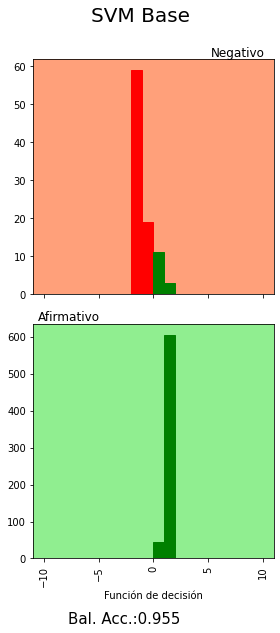

In [ ]:
y_decf = cross_val_predict(svm_clf, x_train,t_train, method='decision_function')
plot_histograms(t_train,y_decf,'SVM Base', acc=ba)

#####Busco los hiperparámetros

In [ ]:
pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('svm',  SVC(max_iter=1e6) )])

params={'svm__class_weight':[{0:1, 1:1}, {0:10, 1:1}, {0:100, 1:1}, {0:1000, 1:1} ],
        'svm__kernel':['rbf', 'linear'],
        'svm__C': np.logspace(-2,2,num=5) }

grid = GridSearchCV( pipeline, param_grid=params, cv=50,
                     scoring='balanced_accuracy', verbose=2 )

grid_results = grid.fit( x_train,t_train )

Fitting 50 folds for each of 40 candidates, totalling 2000 fits
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_weight={0: 1, 1: 1}, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.01, svm__class_wei

In [ ]:
grid_results.best_score_

0.9711538461538461

Notar que el mejor estimador en esta primer exploración de hiperparámetros ya supera levemente el mejor clasificador que se obtuvo con el regresor logístico.

Ahora veo como fué el desempeño en los demás sets de hiperparámetros para ver hacía donde buscar los mejores.

In [ ]:
show_grid_results(grid_results, all=True)

Best estimator: 
 Pipeline(steps=[('poly', PolynomialFeatures()),
                ('svm',
                 SVC(C=10.0, class_weight={0: 1, 1: 1}, max_iter=1000000.0))])

Best score:  0.9711538461538461

rank 	 score 			 parametros
40 	 0.5 		 {'svm__C': 0.01, 'svm__class_weight': {0: 1, 1: 1}, 'svm__kernel': 'rbf'}
35 	 0.9192307692307692 		 {'svm__C': 0.01, 'svm__class_weight': {0: 1, 1: 1}, 'svm__kernel': 'linear'}
36 	 0.8940109890109891 		 {'svm__C': 0.01, 'svm__class_weight': {0: 10, 1: 1}, 'svm__kernel': 'rbf'}
2 	 0.9697802197802199 		 {'svm__C': 0.01, 'svm__class_weight': {0: 10, 1: 1}, 'svm__kernel': 'linear'}
38 	 0.7552747252747252 		 {'svm__C': 0.01, 'svm__class_weight': {0: 100, 1: 1}, 'svm__kernel': 'rbf'}
18 	 0.9655494505494505 		 {'svm__C': 0.01, 'svm__class_weight': {0: 100, 1: 1}, 'svm__kernel': 'linear'}
39 	 0.7545054945054944 		 {'svm__C': 0.01, 'svm__class_weight': {0: 1000, 1: 1}, 'svm__kernel': 'rbf'}
18 	 0.9655494505494505 		 {'svm__C': 0.01, 'svm__class_weig

Ahora hago un ajuste fino, observando que: por lo general no hay buenos resultados para los valores grandes de la constante de regularización ni el peso de la clase '0', y en el 2do mejor estimador el kernel es lineal así que tampoco lo descarto por ahora.

Busco más detalles sobre cuál debiera ser la constante de regularización C, el peso adecuado de las clases y el kernel.


In [ ]:
params = {'svm__class_weight': [{0:1, 1:1}, {0:5, 1:1}, {0:10, 1:1}, {0:25, 1:1},{0:50, 1:1}],
          'svm__kernel': ['linear','rbf'],
          'svm__C': np.logspace(-2,0,num=10) }

grid = GridSearchCV( pipeline, param_grid=params, cv=50,
                     scoring='balanced_accuracy', verbose=2)

grid_results = grid.fit(x_train,t_train)

In [ ]:
show_grid_results(grid_results, all=True)

Best estimator: 
 Pipeline(steps=[('poly', PolynomialFeatures()),
                ('svm',
                 SVC(C=0.21544346900318834, class_weight={0: 10, 1: 1},
                     max_iter=1000000.0))])

Best score:  0.985

rank 	 score 			 parametros
81 	 0.9192307692307692 		 {'svm__C': 0.01, 'svm__class_weight': {0: 1, 1: 1}, 'svm__kernel': 'linear'}
99 	 0.5 		 {'svm__C': 0.01, 'svm__class_weight': {0: 1, 1: 1}, 'svm__kernel': 'rbf'}
65 	 0.9588461538461539 		 {'svm__C': 0.01, 'svm__class_weight': {0: 5, 1: 1}, 'svm__kernel': 'linear'}
91 	 0.8680769230769231 		 {'svm__C': 0.01, 'svm__class_weight': {0: 5, 1: 1}, 'svm__kernel': 'rbf'}
17 	 0.9697802197802199 		 {'svm__C': 0.01, 'svm__class_weight': {0: 10, 1: 1}, 'svm__kernel': 'linear'}
86 	 0.8940109890109891 		 {'svm__C': 0.01, 'svm__class_weight': {0: 10, 1: 1}, 'svm__kernel': 'rbf'}
15 	 0.9705494505494505 		 {'svm__C': 0.01, 'svm__class_weight': {0: 25, 1: 1}, 'svm__kernel': 'linear'}
95 	 0.8434615384615384 		 {'svm__C': 

En vista de esto se vé que el rendimiento no es muy sensible al peso de las clases en este rango de valores, mientras que para valores de C cercanos a 0.21 es mejor utilizar un kernel gausseano (pareciera ser muy sensible a variaciones de C) y para C\~0.01 uno lineal, siendo el primero levemente mejor. 

En consecuencia voy a entrenar un modelo para cada kernel.

#### Modelos finales
Elijo los parámetros definitivos de los modelos basados en SVM.

#####Con kernel Lineal

In [ ]:
svm_lin = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('svm_lin', SVC(kernel='linear', C=0.03, class_weight={0:25,1:1}, max_iter=1e6)) ])

y_pred = cross_val_predict(svm_lin, x_train, t_train, cv=50)

svm_lin_cm = confusion_matrix(t_train, y_pred)
svm_lin_ba = balanced_accuracy_score(t_train, y_pred)
print('Matrix de confusión \n',svm_lin_cm)
print(f'Balanced Accuracy: {svm_lin_ba:.5f}')

Matrix de confusión 
 [[ 90   2]
 [ 11 641]]
Balanced Accuracy: 0.98069


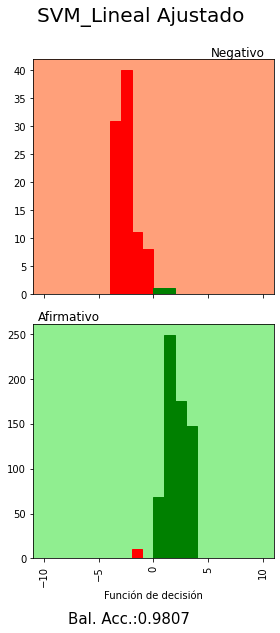

In [ ]:
y_decf = cross_val_predict(svm_lin, x_train, t_train, method='decision_function', cv=50)
plot_histograms(t_train,y_decf, 'SVM_Lineal Ajustado',acc=svm_lin_ba)

#####Gaussiano

In [ ]:
svm_rbf = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('svm_rbf', SVC(kernel='rbf', C=0.2, class_weight={0:25, 1:1}, max_iter=1e6) ) ])

y_pred = cross_val_predict(svm_rbf, x_train,t_train, cv=50)

svm_rbf_cm = confusion_matrix(t_train, y_pred)
svm_rbf_ba = balanced_accuracy_score(t_train,y_pred)

print('Matrix de confusión \n',svm_rbf_cm)
print(f'Balanced Accuracy: {svm_rbf_ba:.5f}')

Matrix de confusión 
 [[ 91   1]
 [ 13 639]]
Balanced Accuracy: 0.98460


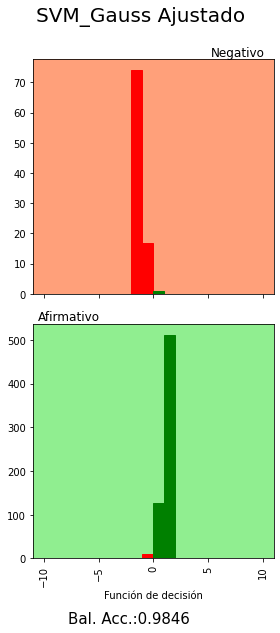

In [ ]:
y_decf = cross_val_predict(svm_rbf, x_train, t_train, cv=50, method='decision_function')
plot_histograms(t_train,y_decf, 'SVM_Gauss Ajustado',acc=svm_rbf_ba)

Ambos modelos superan el balanced accuracy del regresor logístico. El SVM con kernel gausseano parece ser levemente más eficiente para clasificar los samples 0-NEGATIVO, pero un poco menos eficiente para distinguir correctamente los 1-POSITIVO.

Y vemos también que los samples mal clasificados están aún más cerca de la frontera de decisión.

# Evaluación en test

Finalmente, evalúo estos tres métodos en con el set de testeo

#### Logit

In [19]:
logreg_clf = Pipeline([ ('poly', PolynomialFeatures(degree=2) ),
                        ('logit', LogisticRegression(C=7, class_weight={0: 11, 1: 1}, max_iter=1e6) ) ])
logreg_clf.fit(x_train,t_train)

logreg_y = logreg_clf.predict(x_test)
logreg_cm = confusion_matrix(t_test, logreg_y)
logreg_ba = balanced_accuracy_score(t_test, logreg_y)

print('Logistic Regressor final')
print('Matriz de confusión: \n', logreg_cm)
print(f'Balanced Accuracy: {logreg_ba:.5f}')

Logistic Regressor final
Matriz de confusión: 
 [[ 16   1]
 [  1 168]]
Balanced Accuracy: 0.96763


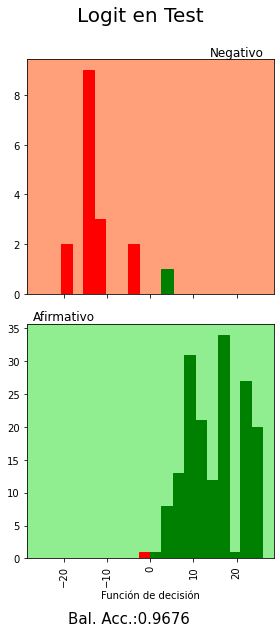

In [20]:
logreg_decf = logreg_clf.decision_function(x_test)
plot_histograms(t_test, logreg_decf,'Logit en Test',acc=logreg_ba)

#### SVM Lineal

In [ ]:
svm_lin_clf = Pipeline([('poly', PolynomialFeatures(degree=2)),
                        ('svm_lin', SVC(kernel='linear', C=0.03, class_weight={0:25,1:1}, max_iter=1e6)) ])
svm_lin_clf.fit(x_train, t_train)

svm_lin_y = svm_lin_clf.predict(x_test)
svm_lin_cm = confusion_matrix(t_test, svm_lin_y)
svm_lin_ba = balanced_accuracy_score(t_test, svm_lin_y)

print('SVM final')
print('Matriz de confusión: \n', svm_lin_cm)
print(f'Balanced Accuracy: {svm_lin_ba:.5f}')

SVM final
Matriz de confusión: 
 [[ 16   1]
 [  2 167]]
Balanced Accuracy: 0.96467


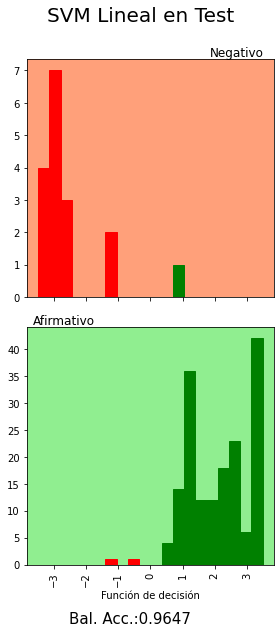

In [ ]:
svm_lin_decf = svm_lin_clf.decision_function(x_test)
plot_histograms(t_test, svm_lin_decf,'SVM Lineal en Test', acc=svm_lin_ba)

#### SVM Gaussiano

In [ ]:
svm_rbf_clf = Pipeline([ ('poly', PolynomialFeatures(degree=2) ),
                         ('svm_rbf', SVC(kernel='rbf', C=0.2, class_weight={0:25, 1:1}, max_iter=1e6) ) ])
svm_rbf_clf.fit(x_train, t_train)

svm_rbf_y = svm_rbf_clf.predict(x_test)
svm_rbf_cm = confusion_matrix(t_test, svm_rbf_y)
svm_rbf_ba = balanced_accuracy_score(t_test, svm_rbf_y)

print('SVM final')
print('Matriz de confusión: \n', svm_rbf_cm)
print(f'Balanced Accuracy: {svm_rbf_ba:.5f}')

SVM final
Matriz de confusión: 
 [[ 16   1]
 [  2 167]]
Balanced Accuracy: 0.96467


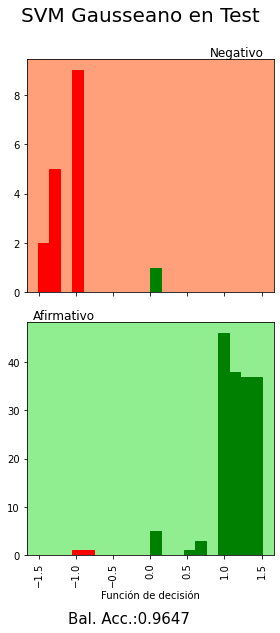

In [ ]:
svm_rbf_decf = svm_rbf_clf.decision_function(x_test)
plot_histograms(t_test, svm_rbf_decf,'SVM Gausseano en Test', acc=svm_rbf_ba)

#### Comparación

Se observa directamente entonces que el regresor logístico es un modelo levemente mejor para esta tarea que el  SVM. \\
Como es sabido, los clasificadores bajaron su performance en la instancia de 
testeo, pero  no todos lo hicieron en la misma medida:

Text(0.5, 0.98, 'Comparación de la métrica en test y train')

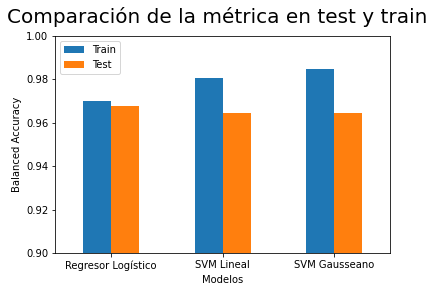

In [ ]:
df_ba = pd.DataFrame(data=[{'name_clf':'logit','ba_train':0.96983,'ba_test':0.96763},
                           {'name_clf':'svm_lin','ba_train':0.98069,'ba_test':0.96467},
                           {'name_clf':'svm_rbf','ba_train':0.98460,'ba_test':0.96467}])

df_ba.plot(x='name_clf', y=['ba_train','ba_test'], kind='bar',
           ylabel='Balanced Accuracy', ylim=(0.9,1),
           xlabel='Modelos',rot=0);
plt.xticks(ticks=[0,1,2], labels=['Regresor Logístico', 'SVM Lineal', 'SVM Gausseano']);
plt.legend(['Train','Test'])
plt.suptitle('Comparación de la métrica en test y train', fontsize=20)

En ese orden, el modelo construido con el regresor logístico mantuvo más su desempeño cuando fué evaluado con el set de testeo, mientras que los basados en SVM disminuyeron.

#Análisis de regresor logistico

In [57]:
df_logreg = pd.DataFrame(data={'feature_name':logreg_clf['poly'].get_feature_names_out(),
                               'coef':logreg_clf['logit'].coef_.ravel()})

In [58]:
df_logreg['exp_coef'] = np.e**df_logreg.coef

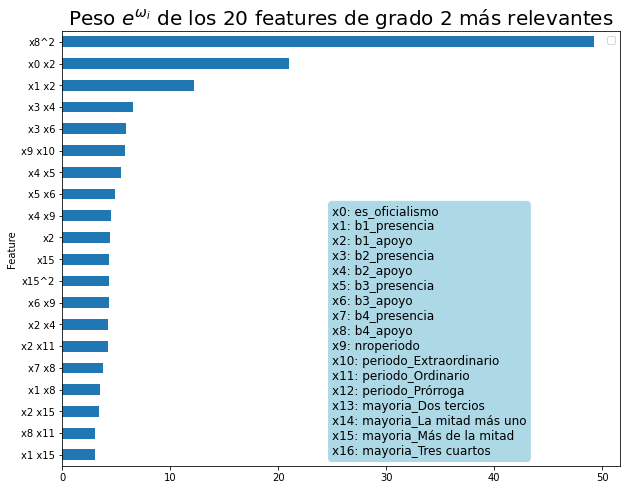

In [90]:
df_logreg.sort_values(by='exp_coef',ascending=True, inplace=True)

fig, ax = plt.subplots(1,1,figsize=(10,8))
df_logreg[-20:].plot(y='exp_coef',x='feature_name',kind='barh', ax=ax)

features_poly = logreg_clf['poly'].get_feature_names_out()[1:18]
features_orig = df.drop(columns='resultado').columns

text = [f'{p}: {o}' for p,o in zip(features_poly,features_orig)]
text = '\n'.join(text)
plt.text(x=25,y=0,s=text, fontsize=12,
         bbox={'boxstyle':'round', 'color':'lightblue'});

plt.ylabel('Feature')
plt.title(r'Peso $e^{\omega_i}$ de los 20 features de grado 2 más relevantes', fontsize=20);
plt.legend('')

Sorpresivamente, el feature que mayor relevancia tiene para el regresor logístico resultó ser 'x8^2', i.e. el cuadrado del indice de apoyo del 4to bloque. Los siguientes en relevancia son más esperables: dan cuenta principalmente de la participación y estatus de los primeros bloques mayoritarios. Luego, en el mismo orden re relevancia, se observan las interacciones para con los demas bloques y algunas pocas de las caracteristicas de las sesiones. Y ya en los últimos casos se vén frecuentemente los features que dan cuenta de las características de la sesión en conjunto con algún bloque.

Finalmente, con los menores coeficientes vemos alguna mezcla aleatoria entre características de la sesión, comportamiento de los bloques y  sus interacciones:

In [95]:
df_logreg.iloc[:10]

,feature_name,coef,exp_coef
24,x0 x6,-2.477233,0.083975
26,x0 x8,-2.189084,0.112019
22,x0 x4,-2.136258,0.118096
137,x9 x11,-1.914987,0.147344
93,x5^2,-1.594330,0.203045
40,x1 x6,-1.525606,0.217489
128,x8 x10,-1.343085,0.261039
38,x1 x4,-1.267549,0.281521
105,x6^2,-1.194102,0.302976
14,x13,-1.102574,0.332016


#Conclusión

Pese a los buenos resultados que se obtuvieron con estos modelos, siendo el mejor el basado en un regresor logístico que erró sólo dos predicciones en testeo y con un mínimo descenso de la métrica obtenida en el entrenamiento, hay que recordar que este modelo no es aplicable aún a sesiones donde se ausente el total de los miembros de alguno de los bloques mayoritarios. Más aún, que no estamos considerando los asuntos que están en votación en dicha sesión, sino sólo cómo responden los miembros de los bloques mayoritarios. 

Esta última aclaración es importante ya que aquí se dá igual importancia a todas las votaciones independientemente del nivel de relevancia directa o impacto que tienen en la sociedad. No se puede suponer que los proyectos de ley que generan más revuelo y son mediatizadas (como la Ley Justina referente al transplante de órganos, la Ley Micaela sobre capacitación de género en instituciones públicas o la Ley de Presupuesto anual) tengan la misma proporción de resultados AFIRMATIVO/NEGATIVO que se tiene en el total de las sesiones, donde hay también votaciones sobre aspectos meramendte técnicos y administrativos.

Por último, muchos diputados/as pertenecientes a estos bloques mayoritarios suelen compartir a través de sus redes sociales una opinión sobre el voto que emitirán en una votación importante. Con lo cual a futuro podría refinarse esta tarea con datos más recientes y quizá otros tipos de modelo, tratar de inferir los valores de _indice de aprobación_ y _porcentaje de presencia_ de los bloques mayoritarios a partir de datos de redes sociales y hacer predicciones sobre futuras votaciones.